In [ ]:
import autograd.numpy as np
from autograd import grad
from autograd.numpy import log, sqrt, sin, cos, exp, pi, prod
from autograd.numpy.random import normal, uniform
from scipy.spatial.distance import pdist, squareform

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import imageio
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

In [ ]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
np.random.seed(2021)

In [ ]:
def mixture(x):
    energy = ((x[0]**2 + x[1]**2)/10 - (cos(2.0*pi*x[0]) + cos(2.0*pi*x[1]))) / 0.5 # 2
    regularizer = ((x[0]**2 + x[1]**2) > 20) * ((x[0]**2 + x[1]**2) - 20)
    return -(energy + regularizer)


def mixture_expand(x, y): return -mixture([x, y])
def function_plot(x, y): return np.exp(mixture([x, y]))

lower, upper = -2.5, 2.5
axis_x = np.linspace(lower, upper, 500)
axis_y = np.linspace(lower, upper, 500)
axis_X, axis_Y = np.meshgrid(axis_x, axis_y)

energy_grid = mixture_expand(axis_X, axis_Y)
prob_grid = function_plot(axis_X, axis_Y)

# Build SVGD *Sampler*

In [ ]:
class Sampler:
    def __init__(self, f=None, xinit=None, lr=1e-3, alpha = 0.9, debug = False):
        self.f = f
        self.lr = lr
        self.debug = debug
        self.alpha = alpha
        self.historical_grad = 0
      
         
        # initialization for SGLD
        self.x = np.array(xinit)
        
    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
    def grad(self, beta):  return grad(self.f)(beta)

    def svgd_step(self, iter):  
        # Check input
        if self.x is None or self.f is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        # adagrad with momentum
        fudge_factor = 1e-6
        if self.debug and (iter+1) % 1000 == 0:
            print('iter ' + str(iter+1))
        
        lnpgrad = np.array([self.grad(self.x[i]) for i in range(self.x.shape[0])])
        
        # calculating the kernel matrix
        kxy, dxkxy = self.svgd_kernel(self.x, h = -1)  
        grad_x = (np.matmul(kxy, lnpgrad) + dxkxy) / self.x.shape[0]  
        
        # adagrad 
        if iter == 0:
            self.historical_grad = self.historical_grad + grad_x ** 2
        else:
            self.historical_grad = self.alpha * self.historical_grad + (1 - self.alpha) * (grad_x ** 2)
        adj_grad = np.divide(grad_x, fudge_factor+np.sqrt(self.historical_grad))
        self.x += self.lr * adj_grad 
     

call our sampler

In [ ]:
xinit = np.random.uniform([lower, lower], [upper, upper], [500, 2])
sampler = Sampler(f=mixture, xinit=xinit, lr=3e-3, alpha = 0.9)

In [ ]:
warm_up = -1
svgd_x = np.array([sampler.x])

In [ ]:
my_images3 = []
svgd_x_path = []
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/SVGD_result/'
if not os.path.isdir(PATH):
    try:
        os.makedirs(PATH)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(PATH):
            pass
        else:
            raise

for iters in range(int(5e4)):
    sampler.svgd_step(iters)
    if iters > warm_up:
        # save the sampels
        svgd_x_path.append(sampler.x)
        if iters % 1000 == 0:
            fig3 = plt.figure(figsize=(4, 4))
            plt.contour(axis_X, axis_Y, prob_grid, 10)
            plt.yticks([-4, -2, 0, 2, 4]) 
            plt.scatter(sampler.x[:,0], sampler.x[:,1], marker='.', s=3, color='k', label="Iteration="+str(iters)) 
            plt.legend(loc="upper left", prop={'size': 10})
            plt.xlim([lower, upper])
            plt.ylim([lower, upper])
            # plt.tight_layout()
            plt.show()
            fig3.canvas.draw()
            image3 = np.frombuffer(fig3.canvas.tostring_rgb(), dtype='uint8').reshape(fig3.canvas.get_width_height()[::-1] + (3,))
            my_images3.append(image3)
            plt.close('all')

               
          

imageio.mimsave(PATH+'single_SVGD_contour_'+str(sampler.lr)+'.gif', my_images3, fps=50)      
# imageio.mimsave(PATH+'CSGLD_PDF'+str(zeta)+"_"+str(psampler.lr)+"_"+str(psampler.T)+'.gif', my_images4, fps=50)

# save the sampels
import pickle
f = open(PATH + 'single_SVGD_samples.txt', 'wb')
pickle.dump(svgd_x_path, f)
f.close()            

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


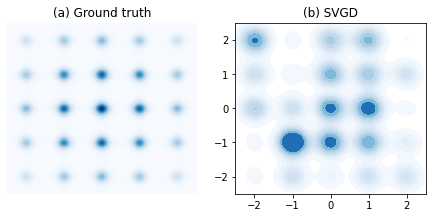

In [ ]:
fig = plt.figure(figsize=(7.5, 3.15))
plt.subplot(1, 2, 1).set_title('(a) Ground truth')
sns.heatmap(prob_grid, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False).invert_yaxis()

warm_sample = 0
split_ = 1
svgd_x = svgd_x.reshape(-1,2)
plt.subplot(1, 2, 2).set_title('(b) SVGD')
ax = sns.kdeplot(sampler.x[:,0], sampler.x[:,1],  cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
plt.savefig(PATH+"SVGD.png")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


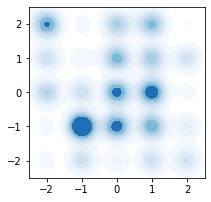

In [ ]:
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/'
fig = plt.figure(figsize=(3.15, 3.15))

warm_sample = 0
split_ = 1
svgd_x = svgd_x.reshape(-1,2)
plt.subplot(1, 1, 1)
ax = sns.kdeplot(sampler.x[:,0], sampler.x[:,1],  cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
plt.savefig(PATH+"simulation_figures/single_SVGD.png")

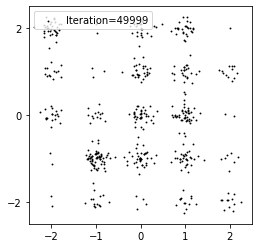

In [ ]:
fig3 = plt.figure(figsize=(4, 4))
#plt.contour(axis_X, axis_Y, prob_grid, 10)
plt.yticks([-4, -2, 0, 2, 4]) 
plt.scatter(sampler.x[:,0], sampler.x[:,1], marker='.', s=3, color='k', label="Iteration="+str(iters)) 
plt.legend(loc="upper left", prop={'size': 10})
plt.xlim([lower, upper])
plt.ylim([lower, upper])
# plt.tight_layout()
plt.show()
fig3.canvas.draw()
image3 = np.frombuffer(fig3.canvas.tostring_rgb(), dtype='uint8').reshape(fig3.canvas.get_width_height()[::-1] + (3,))
my_images3.append(image3)
fig3.savefig(PATH + "samples.png")
plt.close('all')

# Build Parallel Sampler

Call our sampler

In [ ]:
psampler = []
for i in range(5):
    xinit = np.random.uniform([lower, lower], [upper, upper], [100, 2])
    psampler.append(Sampler(f=mixture, xinit=xinit, lr=3e-3, alpha=0.9))

In [ ]:
warm_up = -1

In [ ]:
my_images3 = []
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/SVGD_result/'
if not os.path.isdir(PATH):
    try:
        os.makedirs(PATH)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(PATH):
            pass
        else:
            raise

svgd_x_path = []
for iters in range(int(1e4)):
    for i in range(5):
      psampler[i].svgd_step(iters)
    if iters > warm_up:
        # save the sampels
        svgd_x_path.append(np.array([psampler[i].x for i in range(5)]).reshape((-1,2)))
        
        if iters % 200 == 0:
            svgd_x = np.array([psampler[i].x for i in range(5)]).reshape((-1,2))
            fig3 = plt.figure(figsize=(4, 4))
            plt.contour(axis_X, axis_Y, prob_grid, 10)
            plt.yticks([-4, -2, 0, 2, 4]) 
            plt.scatter(svgd_x[:,0], svgd_x[:,1], marker='.', s=3, color='k', label="Iteration="+str(iters)) 
            plt.legend(loc="upper left", prop={'size': 10})
            plt.xlim([lower, upper])
            plt.ylim([lower, upper])
            # plt.tight_layout()
            plt.show()
            fig3.canvas.draw()
            image3 = np.frombuffer(fig3.canvas.tostring_rgb(), dtype='uint8').reshape(fig3.canvas.get_width_height()[::-1] + (3,))
            my_images3.append(image3)
            plt.close('all')

               
          

imageio.mimsave(PATH+'population_SVGD_contour_'+str(psampler[0].lr)+'.gif', my_images3, fps=50)      
# imageio.mimsave(PATH+'CSGLD_PDF'+str(zeta)+"_"+str(psampler.lr)+"_"+str(psampler.T)+'.gif', my_images4, fps=50)

# save the sampels
import pickle
f = open(PATH + 'population_SVGD_samples.txt', 'wb')
pickle.dump(svgd_x_path, f)
f.close()            

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


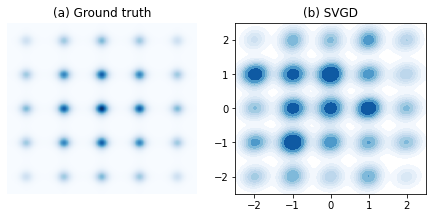

In [ ]:
fig = plt.figure(figsize=(7.5, 3.15))
plt.subplot(1, 2, 1).set_title('(a) Ground truth')
sns.heatmap(prob_grid, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False).invert_yaxis()

warm_sample = 0
split_ = 1
svgd_x = svgd_x.reshape(-1,2)
plt.subplot(1, 2, 2).set_title('(b) SVGD')
ax = sns.kdeplot(svgd_x[:,0], svgd_x[:,1], cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
plt.savefig(PATH+"SVGD_"+str(psampler[0].lr)+".png")

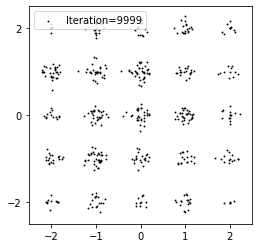

In [ ]:
fig3 = plt.figure(figsize=(4, 4))
# plt.contour(axis_X, axis_Y, prob_grid, 10)
plt.yticks([-4, -2, 0, 2, 4]) 
plt.scatter(svgd_x[:,0], svgd_x[:,1], marker='.', s=3, color='k', label="Iteration="+str(iters)) 
plt.legend(loc="upper left", prop={'size': 10})
plt.xlim([lower, upper])
plt.ylim([lower, upper])
# plt.tight_layout()
plt.show()
fig3.canvas.draw()
image3 = np.frombuffer(fig3.canvas.tostring_rgb(), dtype='uint8').reshape(fig3.canvas.get_width_height()[::-1] + (3,))
my_images3.append(image3)
fig3.savefig(PATH + "samples.png")
plt.close('all')